In [1]:
import os

import numpy as np

import pandas as pd

import seaborn as sns
import ternary
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATAFRAMES = os.path.join("..", "..", "..", "results", "dataframes", "")
FIGURES = os.path.join("..", "..", "..", "results", "figures", "")

# Data preprocessing

In [3]:
df_DC = pd.read_csv(os.path.join(DATAFRAMES, "dataframe_DC-real.csv"))
df_DC["embedding"] = ["DC"]*len(df_DC)
df_DC = df_DC.rename(columns={"pfi": "theta"})
df_DC = df_DC.query("theta > 0")
df_DC.head()

,system,layers,theta,auroc,embedding
1,arxiv,2-6,0.05,0.57,DC
2,arxiv,2-6,0.10,0.64,DC
3,arxiv,2-6,0.15,0.63,DC
4,arxiv,2-6,0.20,0.68,DC
5,arxiv,2-6,0.25,0.69,DC


In [4]:
# Load data
df = pd.read_csv(os.path.join(DATAFRAMES, f"dataframe_reals-single-duplex.csv"))
df = pd.concat([df_DC, df])

print(df.columns)

Index(['system', 'layers', 'theta', 'auroc', 'embedding', 'accuracy', 'pr',
       'intercept', 'coef_distances', 'coef_degrees'],
      dtype='object')


In [5]:
# Global transformations
df["relimp_dists"] = np.abs(df["coef_distances"]) / (np.abs(df["coef_degrees"]) + np.abs(df["coef_distances"]) + np.abs(df["intercept"]))
df["relimp_degs"] = np.abs(df["coef_degrees"]) / (np.abs(df["coef_degrees"]) + np.abs(df["coef_distances"]) + np.abs(df["intercept"]))
df["relimp_int"] = 1 - df["relimp_dists"] - df["relimp_degs"]

In [6]:
# Global melts for easier declarative plotting
df_melt = df.melt(
    id_vars=["system", "embedding", "layers", "theta", "intercept", "coef_distances", "coef_degrees", "relimp_dists", "relimp_degs", "relimp_int"],
    value_vars=["accuracy", "auroc", "pr"],
    var_name="perftype", value_name="perfval"
).melt(
    id_vars=["system", "embedding", "layers", "theta", "perftype", "perfval"],
    value_vars=["intercept", "coef_distances", "coef_degrees", "relimp_dists", "relimp_degs", "relimp_int"],
    var_name="featuretype",
    value_name="featureval"
)

In [7]:
df_melt = df_melt.replace({
    "2-6": "1-2",
    "2-7": "1-3",
    "6-7": "2-3"
})


In [8]:
df_melt = df_melt.query("layers in ['1-2', '1-3', '2-3']")

# Figures

## Performance

In [9]:
df_ = df_melt.query("perftype == 'pr'")
THETAS = sorted(df_.query("embedding != 'DC'")["theta"].unique())

<Figure size 640x480 with 0 Axes>

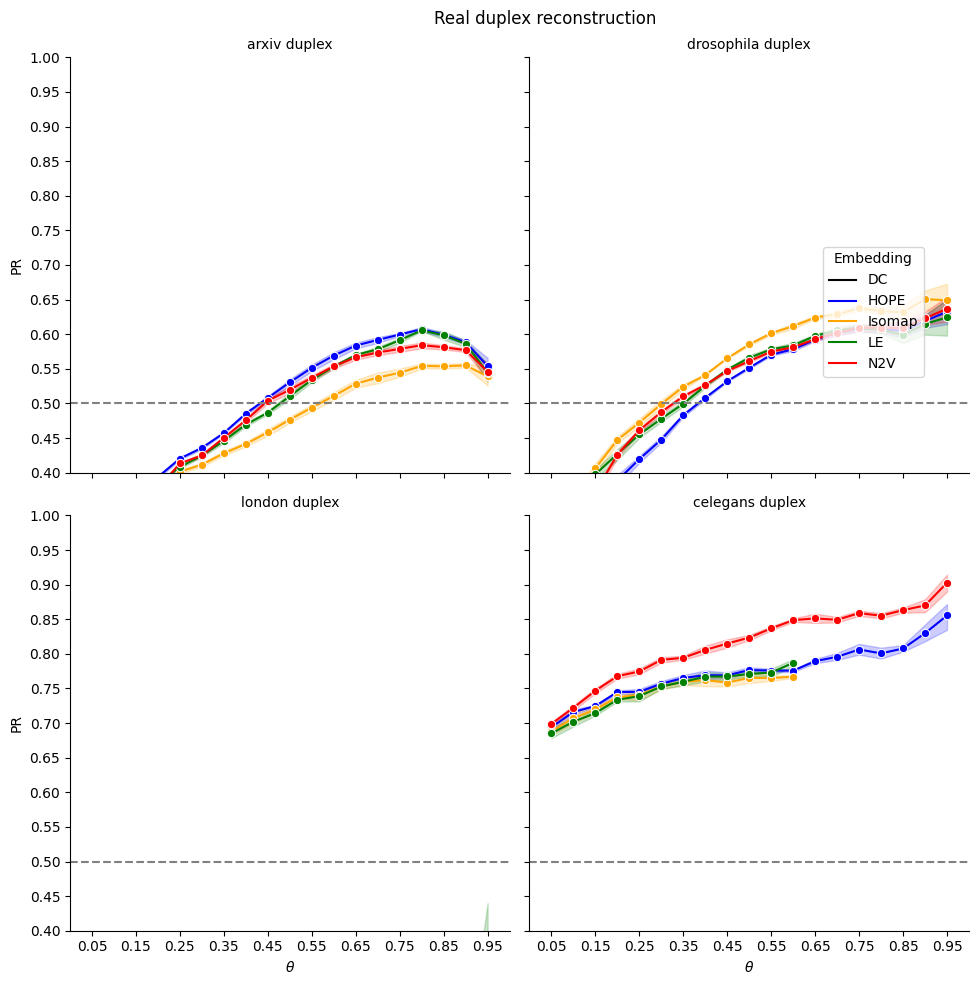

In [10]:
# Instantiate figure
plt.figure()

# Plot data
g = sns.relplot(
    data=df_, kind="line",
    x="theta", y="perfval",
    hue="embedding", palette=["black", "blue", "orange", "green", "red"],
    col="system", col_wrap=2,
    marker="o",
)

# Adjust axes
g.set_axis_labels(r'$\theta$', 'PR')
g.set(
    xlim=(0,1), xticks=THETAS[::2],
    ylim=(0.4, 1), yticks=np.linspace(0.4, 1.0, 13)
)
g.tick_params(axis="x", labelrotation=00)
g.tick_params(axis="y", which="minor")

# Adjust subplots
g.set_titles(col_template="{col_name} duplex")
g.fig.subplots_adjust(top=0.9)
g.refline(y=0.5)

# Adjust figure
g.fig.suptitle("Real duplex reconstruction")
sns.move_legend(g,
    loc="upper right", bbox_to_anchor=(0.85, 0.75),
    title="Embedding",
    frameon=True)

# Save to disk
g.tight_layout()
# g.savefig(
#     os.path.join(FIGURES, "figure_auroc-pfi_hue-embedding_col-ex_data-exarixv-thru-exlondon.png"),
#     transparent=False,
#     facecolor="white",
#     dpi=600)

<Figure size 640x480 with 0 Axes>

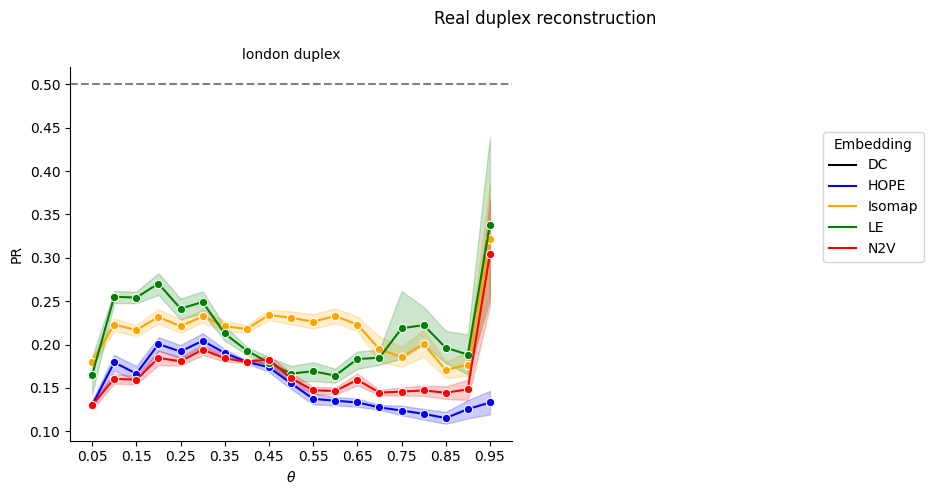

In [12]:
# Instantiate figure
plt.figure()

# Plot data
g = sns.relplot(
    data=df_.query("system == 'london'"), kind="line",
    x="theta", y="perfval",
    hue="embedding", palette=["black", "blue", "orange", "green", "red"],
    col="system", col_wrap=2,
    marker="o",
)

# Adjust axes
g.set_axis_labels(r'$\theta$', 'PR')
g.set(
    xlim=(0,1), xticks=THETAS[::2],
    # ylim=(0.4, 1), yticks=np.linspace(0.4, 1.0, 13)
)
g.tick_params(axis="x", labelrotation=00)
g.tick_params(axis="y", which="minor")

# Adjust subplots
g.set_titles(col_template="{col_name} duplex")
g.fig.subplots_adjust(top=0.9)
g.refline(y=0.5)

# Adjust figure
g.fig.suptitle("Real duplex reconstruction")
sns.move_legend(g,
    loc="upper right", bbox_to_anchor=(0.85, 0.75),
    title="Embedding",
    frameon=True)

# Save to disk
g.tight_layout()
# g.savefig(
#     os.path.join(FIGURES, "figure_auroc-pfi_hue-embedding_col-ex_data-exarixv-thru-exlondon.png"),
#     transparent=False,
#     facecolor="white",
#     dpi=600)

## Coefficients

In [66]:
df_ = df_melt.query("embedding != 'DC'")
df_ = df_.query("featuretype in ['relimp_dists', 'relimp_degs', 'relimp_int']")
df_["featureval"] = df_["featureval"].apply(lambda x: np.abs(x))

<Figure size 640x480 with 0 Axes>

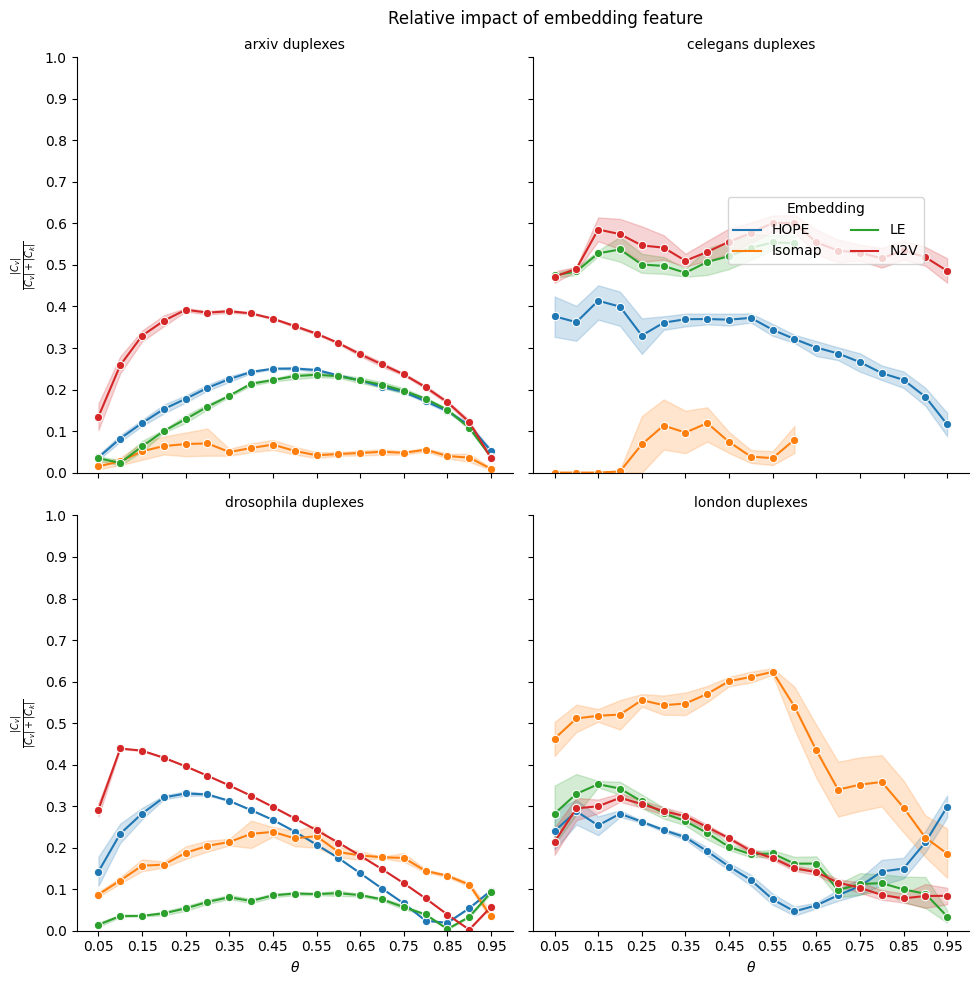

In [67]:
# Instantiate figure
plt.figure()

# Plot data
g = sns.relplot(
    data=df_.query("featuretype == 'relimp_dists'"), kind="line",
    x="theta", y="featureval",
    hue="embedding",
    col="system", col_wrap=2,
    marker="o",
)

# Adjust axes
g.set_axis_labels(r'$\theta$', r'$\frac{|C_v|}{|C_v| + |C_k|}$')
g.set(
    xlim=(0,1), xticks=THETAS[::2],
    ylim=(0.0, 1), yticks=np.linspace(0.0, 1.0, 11)
)
g.tick_params(axis="x", labelrotation=00)
g.tick_params(axis="y", which="minor")

# Adjust subplots
g.set_titles(col_template="{col_name} duplexes")
g.fig.subplots_adjust(top=0.9)

# Adjust figure
g.fig.suptitle("Relative impact of embedding feature")
sns.move_legend(g,
    loc="upper right", bbox_to_anchor=(0.85, 0.8),
    title="Embedding",
    ncol=2,
    frameon=True)

# Save to disk
g.tight_layout()
# g.savefig(
#     os.path.join(FIGURES, "figure_coef-pfi_hue-embedding_col-ex_data-ex01-thru-ex05.png"),
#     transparent=False,
#     facecolor="white",
#     dpi=600)

<Figure size 640x480 with 0 Axes>

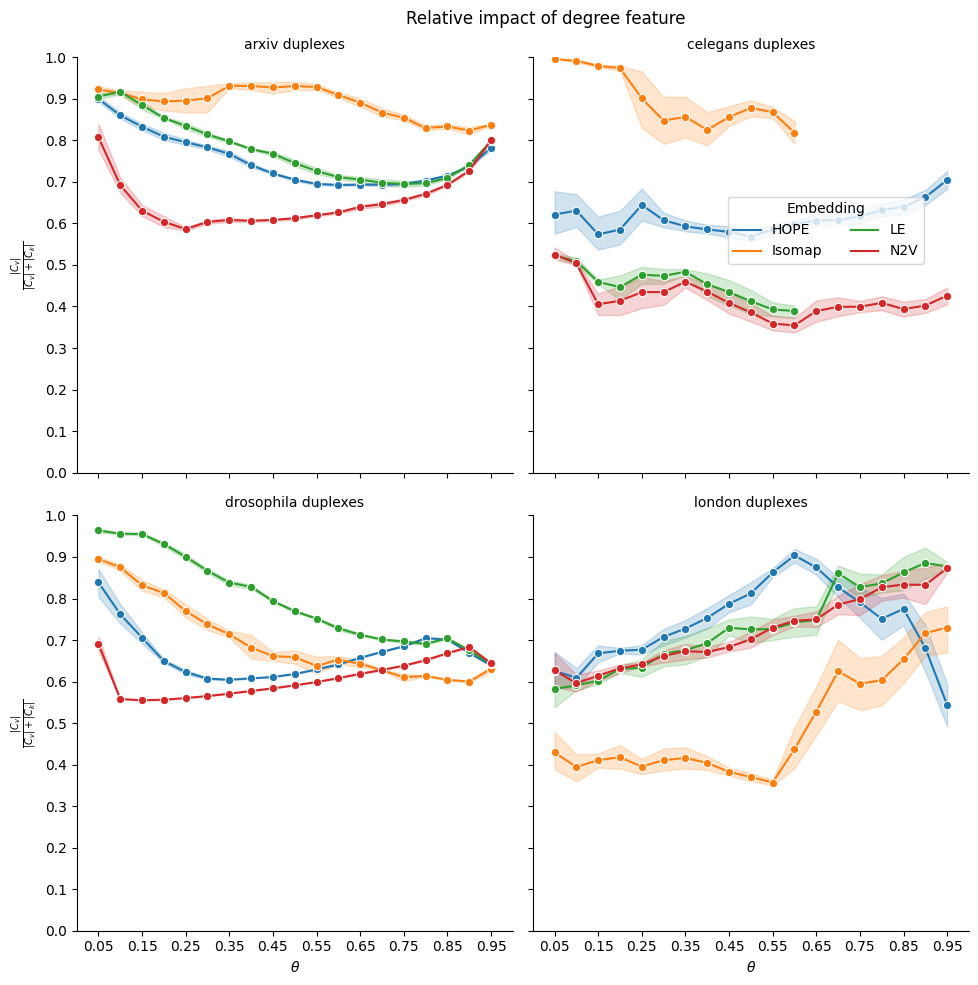

In [68]:
# Instantiate figure
plt.figure()

# Plot data
g = sns.relplot(
    data=df_.query("featuretype == 'relimp_degs'"), kind="line",
    x="theta", y="featureval",
    hue="embedding",
    col="system", col_wrap=2,
    marker="o",
)

# Adjust axes
g.set_axis_labels(r'$\theta$', r'$\frac{|C_v|}{|C_v| + |C_k|}$')
g.set(
    xlim=(0,1), xticks=THETAS[::2],
    ylim=(0.0, 1), yticks=np.linspace(0.0, 1.0, 11)
)
g.tick_params(axis="x", labelrotation=00)
g.tick_params(axis="y", which="minor")

# Adjust subplots
g.set_titles(col_template="{col_name} duplexes")
g.fig.subplots_adjust(top=0.9)

# Adjust figure
g.fig.suptitle("Relative impact of degree feature")
sns.move_legend(g,
    loc="upper right", bbox_to_anchor=(0.85, 0.8),
    title="Embedding",
    ncol=2,
    frameon=True)

# Save to disk
g.tight_layout()
# g.savefig(
#     os.path.join(FIGURES, "figure_coef-pfi_hue-embedding_col-ex_data-ex01-thru-ex05.png"),
#     transparent=False,
#     facecolor="white",
#     dpi=600)

<Figure size 640x480 with 0 Axes>

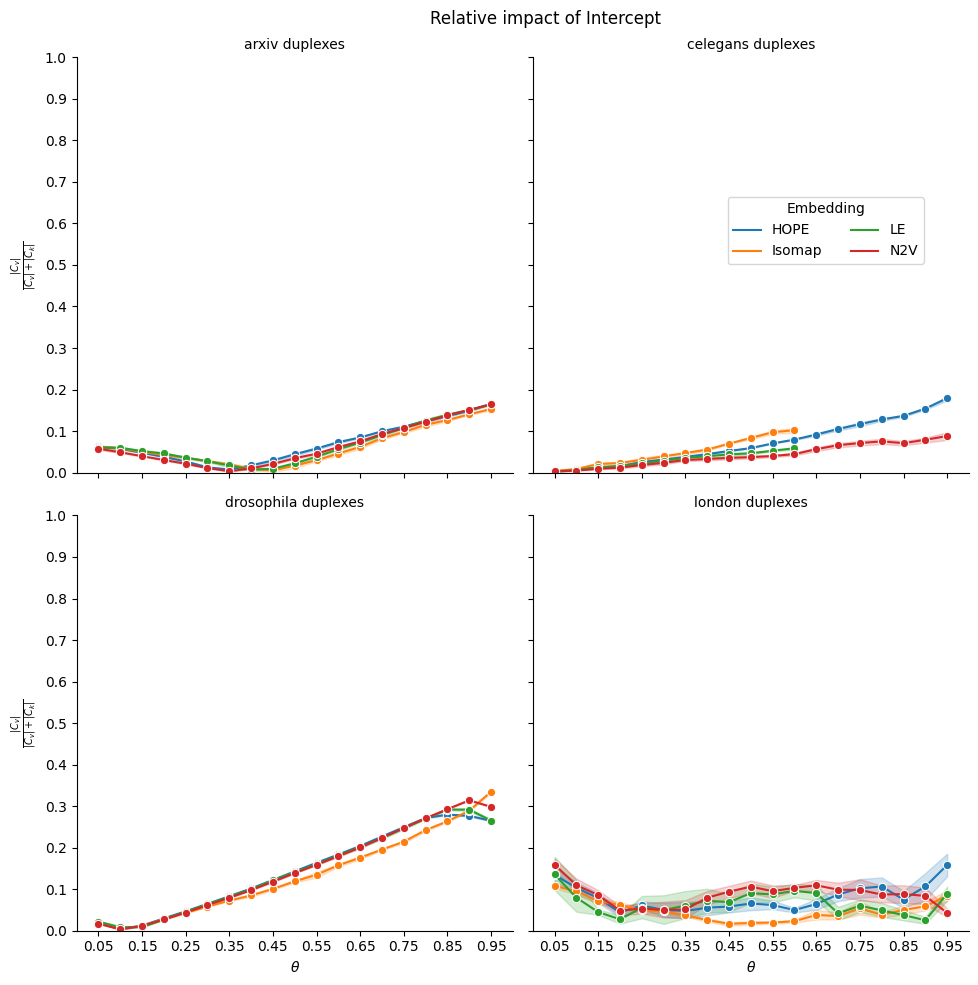

In [69]:
# Instantiate figure
plt.figure()

# Plot data
g = sns.relplot(
    data=df_.query("featuretype == 'relimp_int'"), kind="line",
    x="theta", y="featureval",
    hue="embedding",
    col="system", col_wrap=2,
    marker="o",
)

# Adjust axes
g.set_axis_labels(r'$\theta$', r'$\frac{|C_v|}{|C_v| + |C_k|}$')
g.set(
    xlim=(0,1), xticks=THETAS[::2],
    ylim=(0.0, 1), yticks=np.linspace(0.0, 1.0, 11)
)
g.tick_params(axis="x", labelrotation=00)
g.tick_params(axis="y", which="minor")

# Adjust subplots
g.set_titles(col_template="{col_name} duplexes")
g.fig.subplots_adjust(top=0.9)

# Adjust figure
g.fig.suptitle("Relative impact of Intercept")
sns.move_legend(g,
    loc="upper right", bbox_to_anchor=(0.85, 0.8),
    title="Embedding",
    ncol=2,
    frameon=True)

# Save to disk
g.tight_layout()
# g.savefig(
#     os.path.join(FIGURES, "figure_coef-pfi_hue-embedding_col-ex_data-ex01-thru-ex05.png"),
#     transparent=False,
#     facecolor="white",
#     dpi=600)

## Coefs - Simplex

In [70]:
def plot_simplex_system(system, imbalance = None):
    df_ = df.query("system == @system")[["embedding", "relimp_dists", "relimp_degs", "relimp_int"]]

    figure, tax = ternary.figure(scale=100)

    tax.boundary(linewidth=1)
    tax.gridlines(color="black", multiple=10)

    tax.set_title(system)
    tax.left_axis_label("Dists", offset=0.15)
    tax.right_axis_label("Degs", offset=0.15)
    tax.bottom_axis_label("Ints", offset=0.15)

    pts_n2v = [
        (100*float(x), 100*float(y), 100*float(z))
        for (_,(x,y,z)) in \
            df_.query("embedding == 'N2V'")[["relimp_dists", "relimp_degs", "relimp_int"]].iterrows()
    ]
    pts_le = [
        (100*float(x), 100*float(y), 100*float(z))
        for (_,(x,y,z)) in \
            df_.query("embedding == 'LE'")[["relimp_dists", "relimp_degs", "relimp_int"]].iterrows()
    ]
    pts_hope = [
        (100*float(x), 100*float(y), 100*float(z))
        for (_,(x,y,z)) in \
            df_.query("embedding == 'HOPE'")[["relimp_dists", "relimp_degs", "relimp_int"]].iterrows()
    ]
    pts_isomap = [
        (100*float(x), 100*float(y), 100*float(z))
        for (_,(x,y,z)) in \
            df_.query("embedding == 'Isomap'")[["relimp_dists", "relimp_degs", "relimp_int"]].iterrows()
    ]

    tax.scatter(pts_n2v, marker='s', color='red', label='N2V', s=10, alpha=0.7)
    tax.scatter(pts_le, marker='o', color='green', label='LE', s=10, alpha=0.7)
    tax.scatter(pts_hope, marker='x', color='blue', label='HOPE', s=10, alpha=0.7)
    tax.scatter(pts_isomap, marker='d', color='orange', label='Isomap', s=10, alpha=0.7)

    if imbalance is not None:
        tax.left_parallel_line(imbalance, color="black", linestyle="--")
        tax.right_parallel_line(imbalance, color="black", linestyle="--")

    tax.legend()
    tax.ticks(axis='lbr', linewidth=1, multiple=10, offset=0.02)

    tax.clear_matplotlib_ticks()
    tax.get_axes().axis("off")

    ternary.plt.show()

def plot_simplex_embedding(embedding):
    df_ = df.query("embedding == @embedding")[["system", "relimp_dists", "relimp_degs", "relimp_int"]]

    figure, tax = ternary.figure(scale=100)

    tax.boundary(linewidth=1)
    tax.gridlines(color="black", multiple=10)

    tax.set_title(embedding)
    tax.left_axis_label("Dists", offset=0.15)
    tax.right_axis_label("Degs", offset=0.15)
    tax.bottom_axis_label("Ints", offset=0.15)

    pts_sys = lambda system: [
        (100*float(x), 100*float(y), 100*float(z))
        for (_,(x,y,z)) in \
            df_.query("system == @system")[["relimp_dists", "relimp_degs", "relimp_int"]].iterrows()
    ]

    pts_arxiv = pts_sys("arxiv")
    pts_celegans = pts_sys("celegans")
    pts_drosophila = pts_sys("drosophila")
    pts_london = pts_sys("london")


    tax.scatter(pts_arxiv, marker='s', color='red', label='arxiv', s=10, alpha=0.7)
    tax.scatter(pts_celegans, marker='o', color='green', label='celegans', s=10, alpha=0.7)
    tax.scatter(pts_drosophila, marker='x', color='blue', label='drosophila', s=10, alpha=0.7)
    tax.scatter(pts_london, marker='d', color='orange', label='london', s=10, alpha=0.7)

    tax.legend()
    tax.ticks(axis='lbr', linewidth=1, multiple=10, offset=0.02)

    tax.clear_matplotlib_ticks()
    tax.get_axes().axis("off")

    ternary.plt.show()

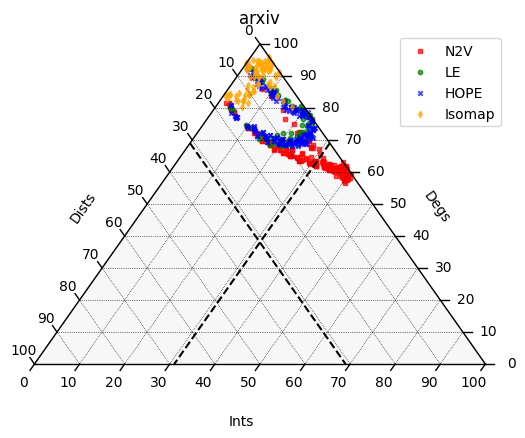

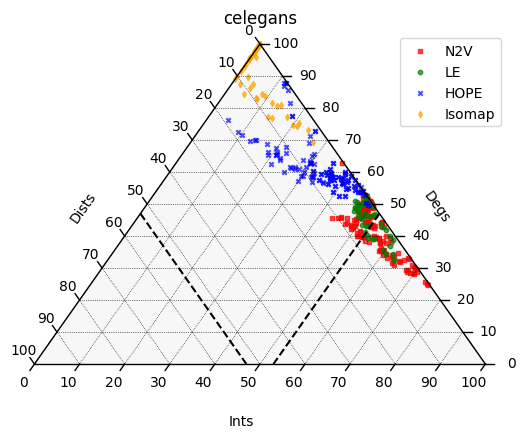

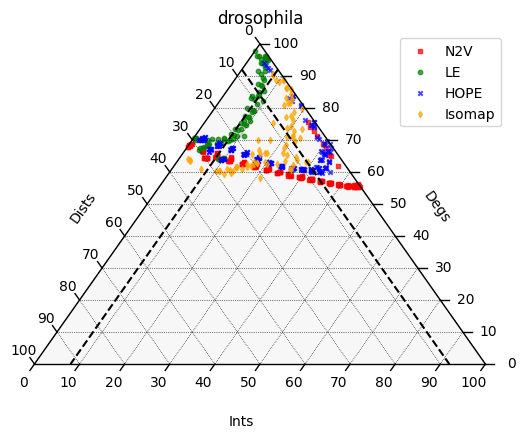

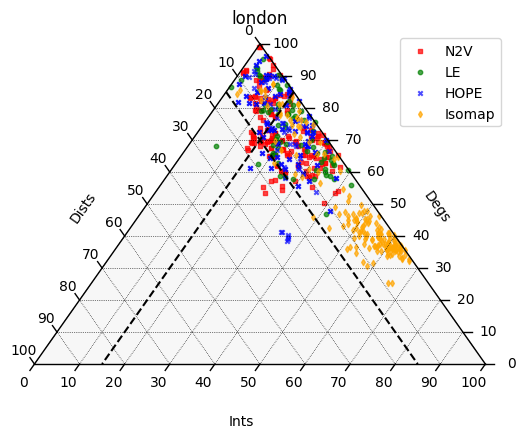

In [72]:
plot_simplex_system("arxiv", 31)
plot_simplex_system("celegans", 53)
plot_simplex_system("drosophila", 8)
plot_simplex_system("london", 15)

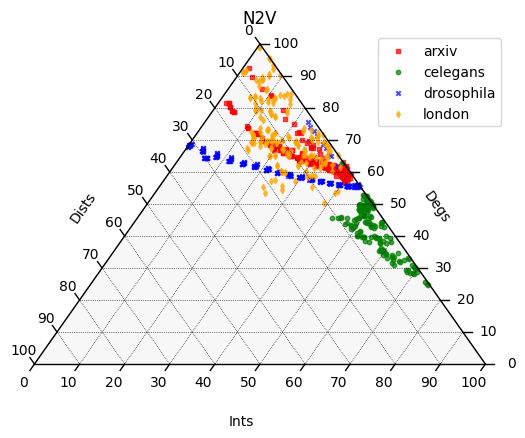

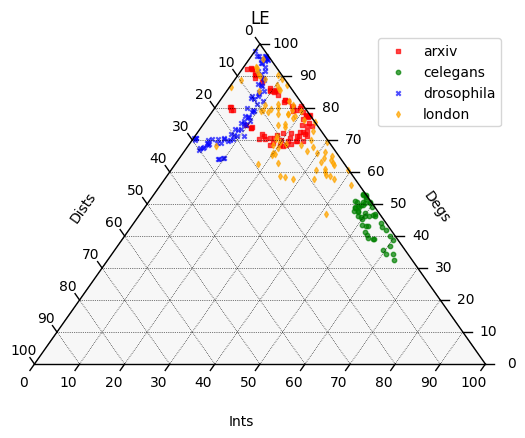

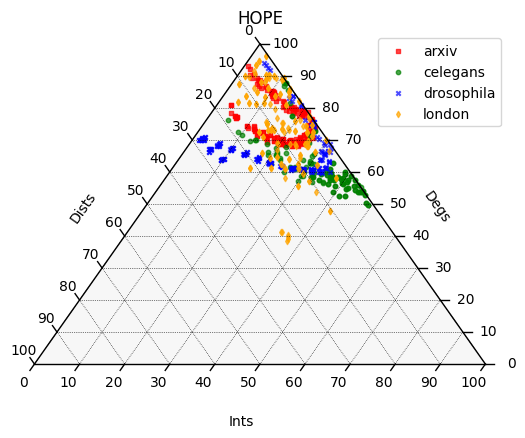

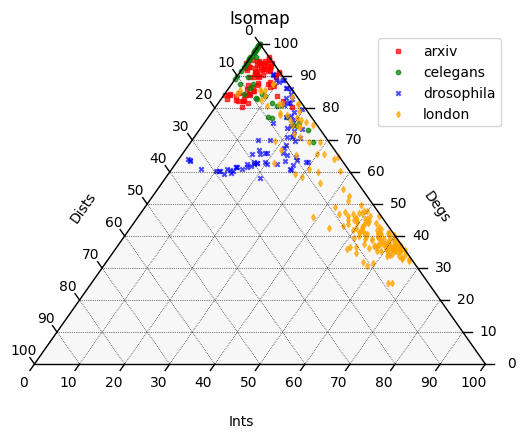

In [53]:
plot_simplex_embedding("N2V")
plot_simplex_embedding("LE")
plot_simplex_embedding("HOPE")
plot_simplex_embedding("Isomap")

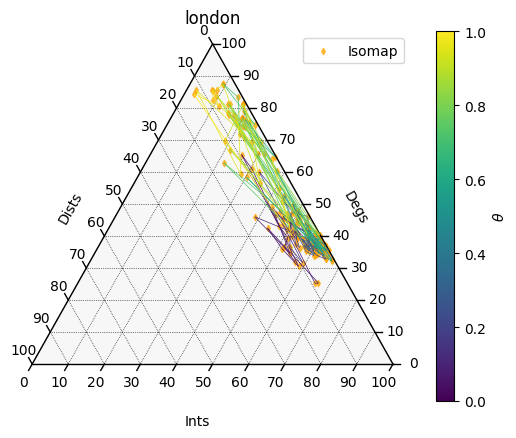

In [41]:
system = 'london'
df_ = df.query("system == @system")[["embedding", "relimp_dists", "relimp_degs", "relimp_int"]]

figure, tax = ternary.figure(scale=100)

tax.boundary(linewidth=1)
tax.gridlines(color="black", multiple=10)

tax.set_title(system)
tax.left_axis_label("Dists", offset=0.15)
tax.right_axis_label("Degs", offset=0.15)
tax.bottom_axis_label("Ints", offset=0.15)

pts_n2v = [
    (100*float(x), 100*float(y), 100*float(z))
    for (_,(x,y,z)) in \
        df_.query("embedding == 'N2V'")[["relimp_dists", "relimp_degs", "relimp_int"]].iterrows()
]
pts_le = [
    (100*float(x), 100*float(y), 100*float(z))
    for (_,(x,y,z)) in \
        df_.query("embedding == 'LE'")[["relimp_dists", "relimp_degs", "relimp_int"]].iterrows()
]
pts_hope = [
    (100*float(x), 100*float(y), 100*float(z))
    for (_,(x,y,z)) in \
        df_.query("embedding == 'HOPE'")[["relimp_dists", "relimp_degs", "relimp_int"]].iterrows()
]
pts_isomap = [
    (100*float(x), 100*float(y), 100*float(z))
    for (_,(x,y,z)) in \
        df_.query("embedding == 'Isomap'")[["relimp_dists", "relimp_degs", "relimp_int"]].iterrows()
]

# tax.scatter(pts_n2v, marker='s', color='red', label='N2V', s=10, alpha=0.7)
# tax.scatter(pts_le, marker='o', color='green', label='LE', s=10, alpha=0.7)
# tax.scatter(pts_hope, marker='x', color='blue', label='HOPE', s=10, alpha=0.7)
tax.scatter(pts_isomap, marker='d', color='orange', label='Isomap', s=10, alpha=0.7)
c1 = tax.plot_colored_trajectory(pts_isomap, linewidth=0.5, alpha=1)
# c2 = tax.plot_colored_trajectory(pts_hope, linestyle='-', linewidth=1, label='HOPE')
figure.colorbar(c1, label=r"$\theta$")

# if imbalance is not None:
#     tax.left_parallel_line(imbalance, color="black", linestyle="--")
#     tax.right_parallel_line(imbalance, color="black", linestyle="--")

tax.legend()
tax.ticks(axis='lbr', linewidth=1, multiple=10, offset=0.02)

tax.clear_matplotlib_ticks()
tax.get_axes().axis("off")

ternary.plt.show()